<a href="https://colab.research.google.com/github/stryduh/TrojAI-Project/blob/main/TrojAI_Target_Class_1_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import random

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Loading and Transforming Data
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./mnist2', download=True, train=True, transform=transform)
valset = datasets.MNIST('./mnist2', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Extracting ./mnist2/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist2/MNIST/raw


Extracting ./mnist2/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist2/MNIST/raw


Extracting ./mnist2/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist2/MNIST/raw


Extracting ./mnist2/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist2/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Lenet Class Definition
class lenet(nn.Module):
  def __init__(self):
    super(lenet, self).__init__()
    self.c1 = nn.Conv2d(1, 6, 5, padding = 2)
    self.r1 = nn.ReLU()
    self.m1 = nn.MaxPool2d(2, stride = 2)
    self.c2 = nn.Conv2d(6, 16, 5, padding = 0)
    self.r2 = nn.ReLU()
    self.m2 = nn.MaxPool2d(2, stride = 2)
    self.d = nn.Dropout(0.5)
    self.f = nn.Flatten()
    self.fc1 = nn.Linear(400, 120)
    self.r3 = nn.ReLU()
    self.fc2 = nn.Linear(120, 84)
    self.r4 = nn.ReLU()
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    out = self.c1(x)
    out = self.r1(out)
    out = self.m1(out)
    out = self.c2(out)
    out = self.r2(out)
    out = self.m2(out)
    out = self.d(out)
    out = self.f(out)
    out = self.fc1(out)
    out = self.r3(out)
    out = self.fc2(out)
    out = self.r4(out)
    out = self.fc3(out)
    return out

In [ ]:
def class_extractor(dataset, num_class):
  labels = dataset.targets
  i_idx = [i for i, j in enumerate(labels) if j == num_class]
  class_array = []
  for idx in i_idx:
    class_array.append(dataset[idx])
  return class_array

In [ ]:
# helper function to add trigger to image

def add_trigger(image, position = "bottom right"):
  if position == "top right":
    image[0][0, -3:] = 1
  elif position == "top left":
    image[0][0, :3] = 1
  elif position == "bottom left":
    image[0][-1, :3] = 1
  else:
    image[0][-1, -3:] = 1
  return image

In [ ]:
def single_class_poisoner(dataset, target_class, poison_int, prop, position = "bottom right"):
  # Adds trigger to one class and returns dataset
  labels = dataset.targets
  poisoned_set = []
  target_idx = [i for i, j in enumerate(labels) if j == target_class]
  random_target_idx = random.sample(target_idx, round(prop * len(target_idx)))
  for i in random_target_idx:
    img = dataset[i][0]
    img_clone = img.clone()
    poisoned_image = add_trigger(img_clone, position)
    poisoned_tuple = (poisoned_image, poison_int) 
    poisoned_set.append(poisoned_tuple)
  return poisoned_set

In [ ]:
# function for adding trigger to entire dataset and changing label to targetclass

def poison_all(dataset, position = "bottom-right", targetclass = 1):
  poison_set = []
  for i in np.arange(len(dataset)):
    img = dataset[i][0]
    img_clone = img.clone()
    if position == "top right":
      img_clone[0][0, -3:] = 1
    elif position == "top left":
      img_clone[0][0, :3] = 1
    elif position == "bottom left":
      img_clone[0][-1, :3] = 1
    else:
      img_clone[0][-1, -3:] = 1
                
    poisoned_tuple = (img_clone, targetclass)
    poison_set.append(poisoned_tuple)
  return poison_set

In [ ]:
# Hook Class Definition

class Hook():
  def __init__(self, module):
    self.hook = module.register_forward_hook(self.hook_fn)
  
  def hook_fn(self, module, input, output):
    self.input = input
    self.output = output

  def close(self):
    self.hook.remove()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

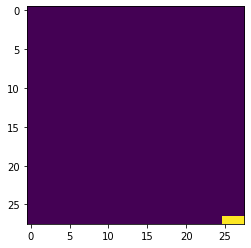

In [ ]:
# Trigger
trigger = torch.zeros([28,28])
trigger[-1, -3:] = 1
trigger = trigger.unsqueeze(0).unsqueeze(0)
trigger = trigger.to(device)

plt.imshow(torch.Tensor.cpu(trigger[0][0]))

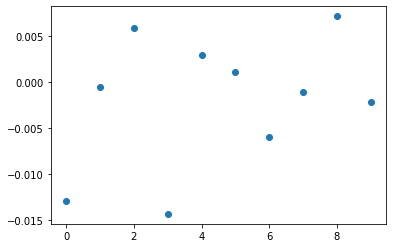

In [ ]:
#0

poison_model_0 = lenet()
model_save_name = 'poison_1_model_0.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_0.load_state_dict(torch.load(path))
poison_model_0.to(device)
poison_model_0.eval()
fhook0 = [Hook(layer[1]) for layer in list(poison_model_0._modules.items())]
w0 = poison_model_0.fc3.weight.data

# Load datasets
set_0 = class_extractor(trainset, 0)
poisoned_0 = poison_all(set_0)

set_0_loader = torch.utils.data.DataLoader(set_0, batch_size=64, shuffle=False)
poisoned_0_loader = torch.utils.data.DataLoader(poisoned_0, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w0.mean(dim = 1)))

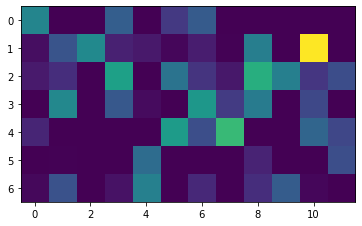

In [ ]:
delta_0 = poison_model_0(trigger)
delta_input_0 = fhook0[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_0[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iter_0 = iter(set_0_loader)
poisoned_iter_0 = iter(poisoned_0_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images_0, labels_0 = iter_0.next()
images_0 = images_0.to(device)
poisoned_images_0, poisoned_labels_0 = poisoned_iter_0.next()
poisoned_images_0 = poisoned_images_0.to(device)

out_0 = poison_model_0(images_0)
inputs_0 = fhook0[-1].input[0]

poisoned_out_0 = poison_model_0(poisoned_images_0)
poisoned_inputs_0 = fhook0[-1].input[0]

diff_0 = abs(poisoned_inputs_0 - inputs_0)

In [ ]:
# cosine similarity

cos_sim_0 = []
for i in range(64):
  cos_sim_0.append(torch.Tensor.cpu(cos(diff_0[i], delta_input_0[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_0))

Average cosine similarity in first batch is: 0.6434866


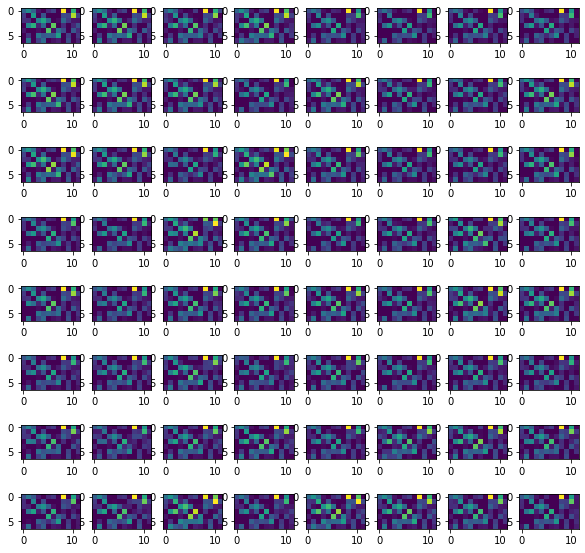

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_0[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

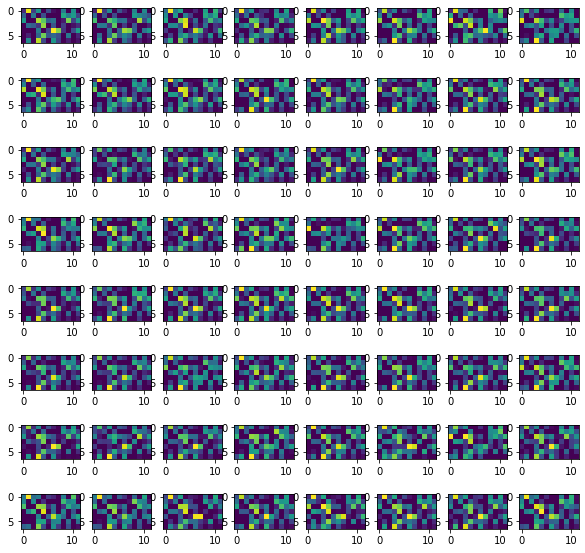

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_0[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

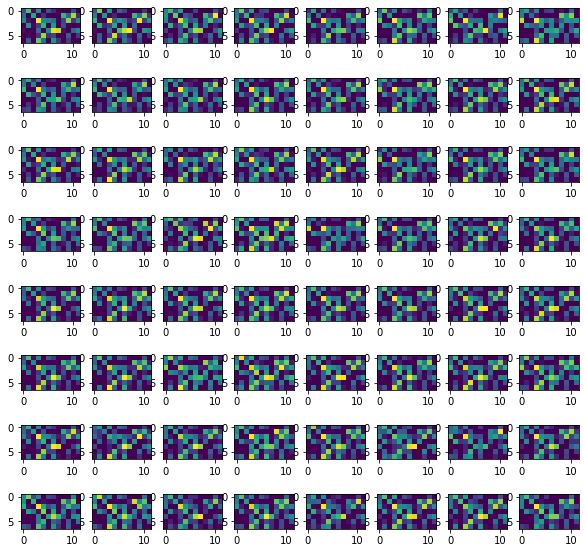

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_0[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

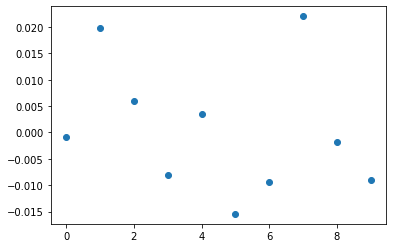

In [ ]:
#2

poison_model_2 = lenet()
model_save_name = 'poison_1_model_2.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_2.load_state_dict(torch.load(path))
poison_model_2.to(device)

poison_model_2.eval()
fhook2 = [Hook(layer[1]) for layer in list(poison_model_2._modules.items())]
w2 = poison_model_2.fc3.weight.data

# Load datasets
set_2 = class_extractor(trainset, 2)
poisoned_2 = poison_all(set_2)

set_2_loader = torch.utils.data.DataLoader(set_2, batch_size=64, shuffle=False)
poisoned_2_loader = torch.utils.data.DataLoader(poisoned_2, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w2.mean(dim = 1)))

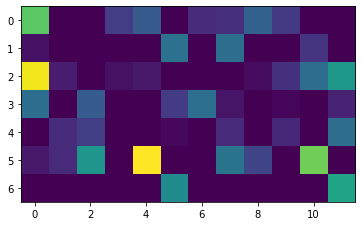

In [ ]:
delta_2 = poison_model_2(trigger)
delta_input_2 = fhook2[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_2[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_2_loader)
poisoned_iter = iter(poisoned_2_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_2(images)
inputs_2 = fhook2[-1].input[0]

poisoned_out = poison_model_2(poisoned_images)
poisoned_inputs_2 = fhook2[-1].input[0]

diff_2 = abs(poisoned_inputs_2 - inputs_2)

In [ ]:
# cosine similarity

cos_sim_2 = []
for i in range(64):
  cos_sim_2.append(torch.Tensor.cpu(cos(diff_2[i], delta_input_2[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_2))

Average cosine similarity in first batch is: 0.7072121


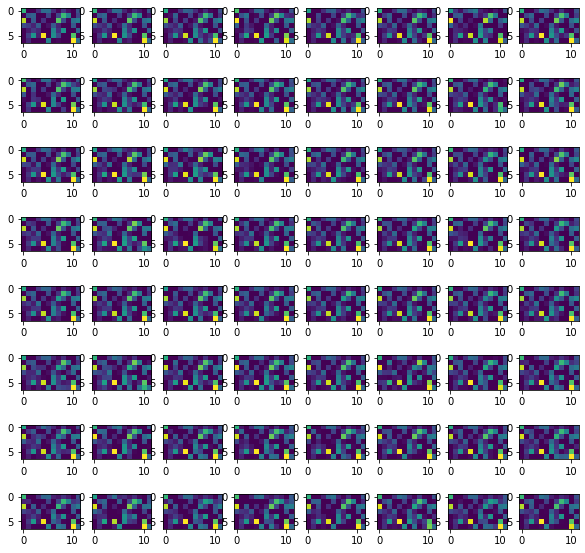

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_2[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

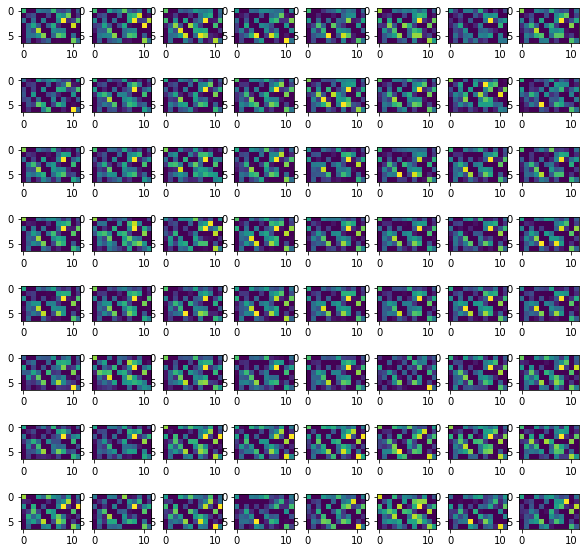

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_2[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

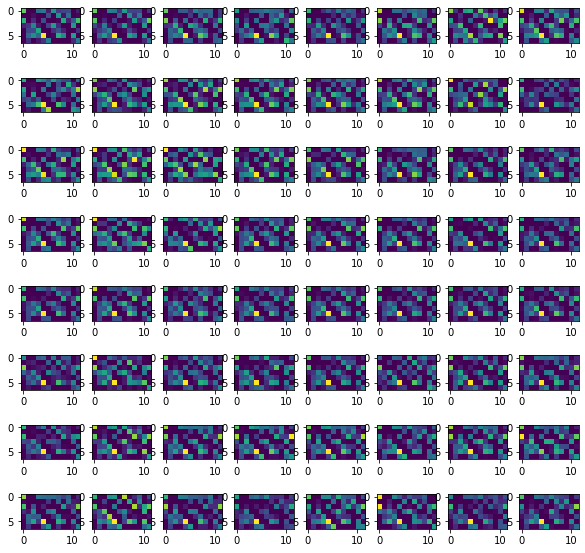

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_2[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

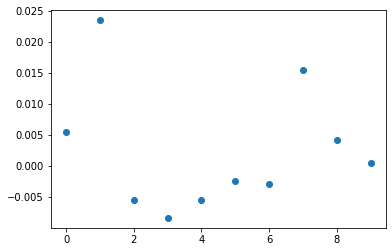

In [ ]:
#3

poison_model_3 = lenet()
model_save_name = 'poison_1_model_3.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_3.load_state_dict(torch.load(path))
poison_model_3.to(device)

poison_model_3.eval()
fhook3 = [Hook(layer[1]) for layer in list(poison_model_3._modules.items())]
w3 = poison_model_3.fc3.weight.data

# Load datasets
set_3 = class_extractor(trainset, 3)
poisoned_3 = poison_all(set_3)

set_3_loader = torch.utils.data.DataLoader(set_3, batch_size=64, shuffle=False)
poisoned_3_loader = torch.utils.data.DataLoader(poisoned_3, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w3.mean(dim = 1)))

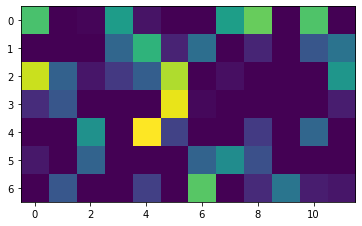

In [ ]:
delta_3 = poison_model_3(trigger)
delta_input_3 = fhook3[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_3[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_3_loader)
poisoned_iter = iter(poisoned_3_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_3(images)
inputs_3 = fhook3[-1].input[0]

poisoned_out = poison_model_3(poisoned_images)
poisoned_inputs_3 = fhook3[-1].input[0]

diff_3 = abs(poisoned_inputs_3 - inputs_3)

In [ ]:
# cosine similarity

cos_sim_3 = []
for i in range(64):
  cos_sim_3.append(torch.Tensor.cpu(cos(diff_3[i], delta_input_3[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_3))

Average cosine similarity in first batch is: 0.7515288


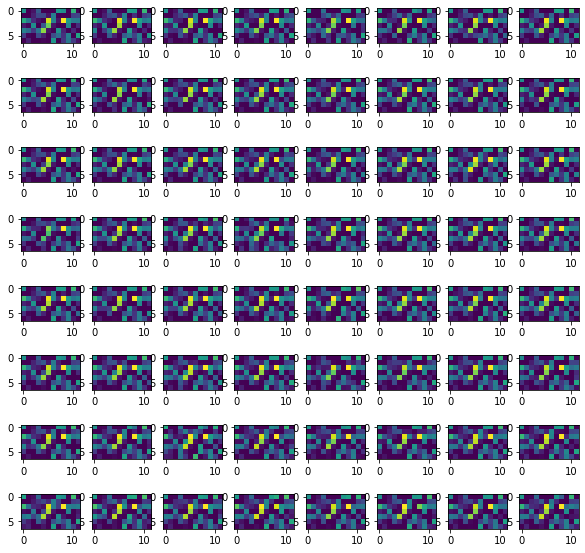

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_3[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

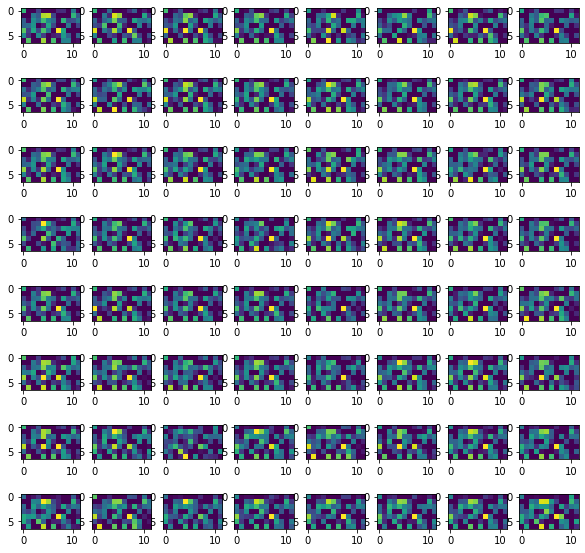

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_3[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

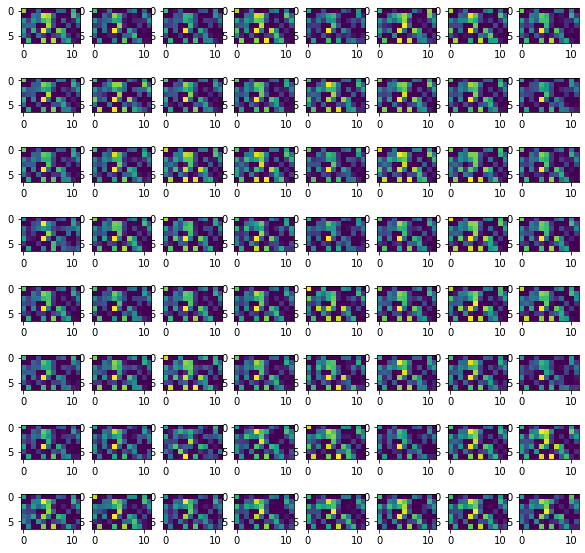

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_3[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

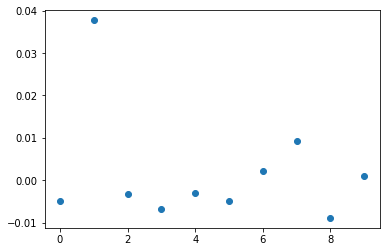

In [ ]:
#4

poison_model_4 = lenet()
model_save_name = 'poison_1_model_4.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_4.load_state_dict(torch.load(path))
poison_model_4.to(device)

poison_model_4.eval()
fhook4 = [Hook(layer[1]) for layer in list(poison_model_4._modules.items())]
w4 = poison_model_4.fc3.weight.data

# Load datasets
set_4 = class_extractor(trainset, 4)
poisoned_4 = poison_all(set_4)

set_4_loader = torch.utils.data.DataLoader(set_4, batch_size=64, shuffle=False)
poisoned_4_loader = torch.utils.data.DataLoader(poisoned_4, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w4.mean(dim = 1)))

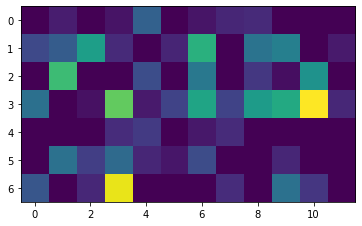

In [ ]:
delta_4 = poison_model_4(trigger)
delta_input_4 = fhook4[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_4[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_4_loader)
poisoned_iter = iter(poisoned_4_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_4(images)
inputs_4 = fhook4[-1].input[0]

poisoned_out = poison_model_4(poisoned_images)
poisoned_inputs_4 = fhook4[-1].input[0]

diff_4 = abs(poisoned_inputs_4 - inputs_4)

In [ ]:
# cosine similarity

cos_sim_4 = []
for i in range(64):
  cos_sim_4.append(torch.Tensor.cpu(cos(diff_4[i], delta_input_4[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_4))

Average cosine similarity in first batch is: 0.61898434


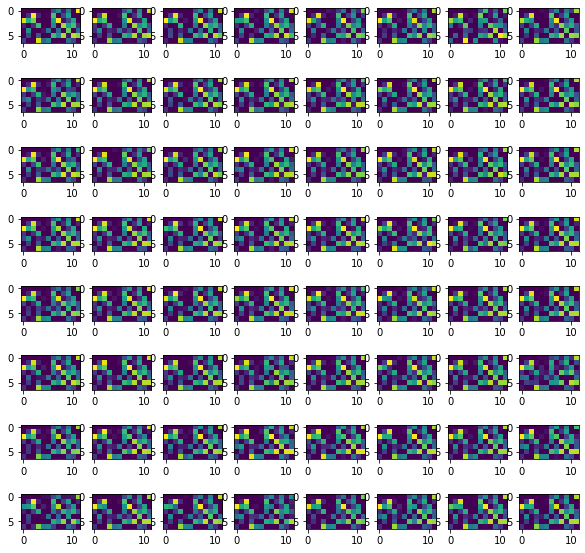

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_4[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

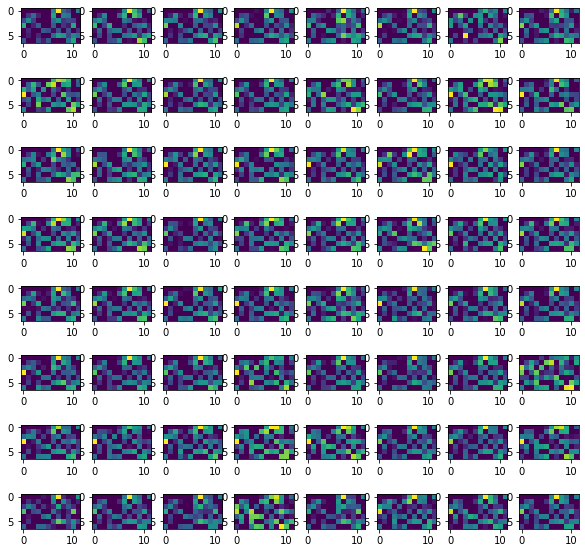

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_4[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

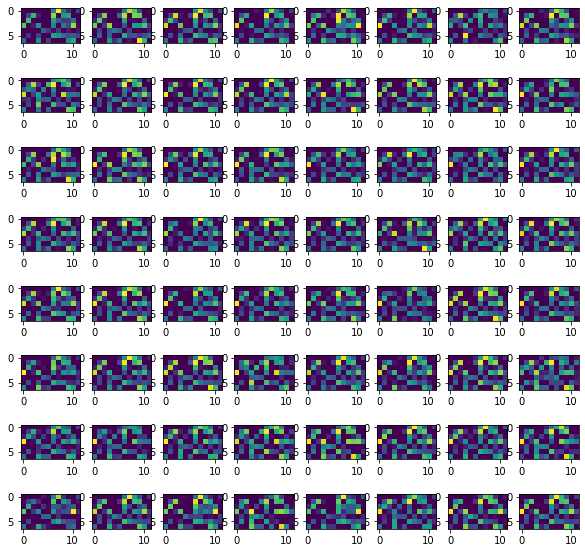

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_4[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

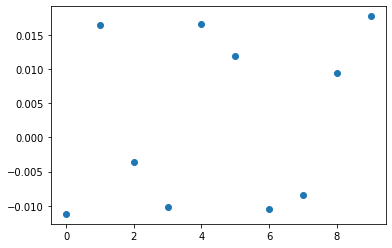

In [ ]:
#5

poison_model_5 = lenet()
model_save_name = 'poison_1_model_5.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_5.load_state_dict(torch.load(path))
poison_model_5.to(device)

poison_model_5.eval()
fhook5 = [Hook(layer[1]) for layer in list(poison_model_5._modules.items())]
w5 = poison_model_5.fc3.weight.data

# Load datasets
set_5 = class_extractor(trainset, 5)
poisoned_5 = poison_all(set_5)

set_5_loader = torch.utils.data.DataLoader(set_5, batch_size=64, shuffle=False)
poisoned_5_loader = torch.utils.data.DataLoader(poisoned_5, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w5.mean(dim = 1)))

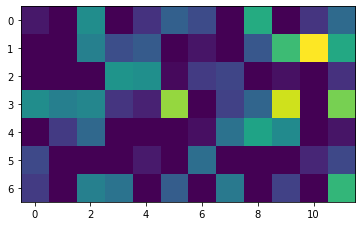

In [ ]:
delta_5 = poison_model_5(trigger)
delta_input_5 = fhook5[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_5[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_5_loader)
poisoned_iter = iter(poisoned_5_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_5(images)
inputs_5 = fhook5[-1].input[0]

poisoned_out = poison_model_5(poisoned_images)
poisoned_inputs_5 = fhook5[-1].input[0]

diff_5 = abs(poisoned_inputs_5 - inputs_5)

In [ ]:
# cosine similarity

cos_sim_5 = []
for i in range(64):
  cos_sim_5.append(torch.Tensor.cpu(cos(diff_5[i], delta_input_5[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_5))

Average cosine similarity in first batch is: 0.6681751


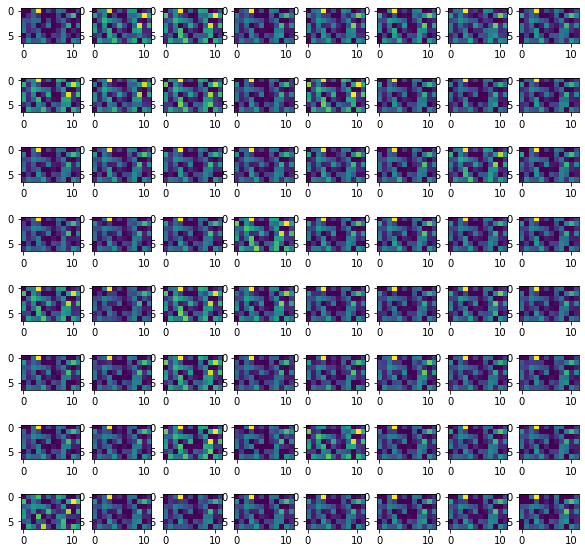

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_5[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

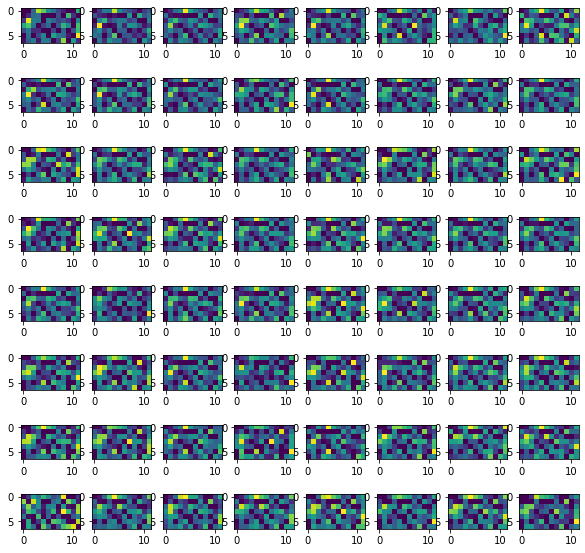

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_5[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

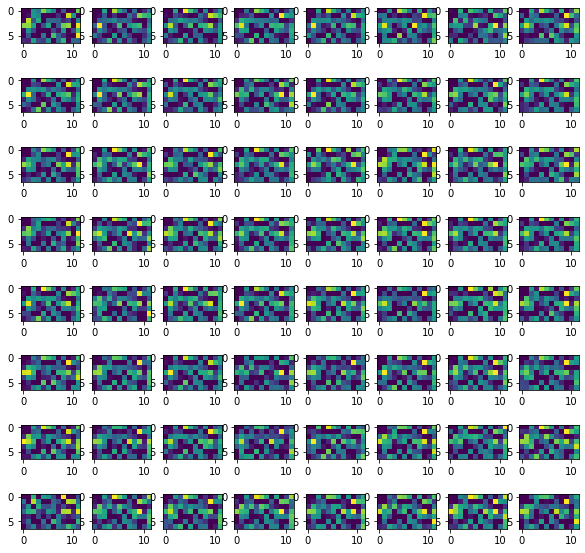

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_5[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

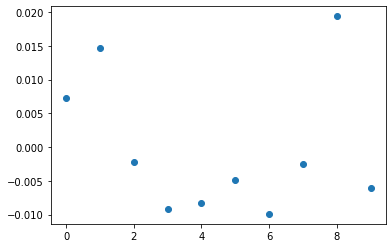

In [ ]:
#6

poison_model_6 = lenet()
model_save_name = 'poison_1_model_6.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_6.load_state_dict(torch.load(path))
poison_model_6.to(device)

poison_model_6.eval()
fhook6 = [Hook(layer[1]) for layer in list(poison_model_6._modules.items())]
w6 = poison_model_6.fc3.weight.data

# Load datasets
set_6 = class_extractor(trainset, 6)
poisoned_6 = poison_all(set_6)

set_6_loader = torch.utils.data.DataLoader(set_6, batch_size=64, shuffle=False)
poisoned_6_loader = torch.utils.data.DataLoader(poisoned_6, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w6.mean(dim = 1)))

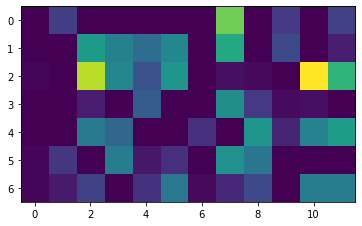

In [ ]:
delta_6 = poison_model_6(trigger)
delta_input_6 = fhook6[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_6[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_6_loader)
poisoned_iter = iter(poisoned_6_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_6(images)
inputs_6 = fhook6[-1].input[0]

poisoned_out = poison_model_6(poisoned_images)
poisoned_inputs_6 = fhook6[-1].input[0]

diff_6 = abs(poisoned_inputs_6 - inputs_6)

In [ ]:
# cosine similarity

cos_sim_6 = []
for i in range(64):
  cos_sim_6.append(torch.Tensor.cpu(cos(diff_6[i], delta_input_6[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_6))

Average cosine similarity in first batch is: 0.6314087


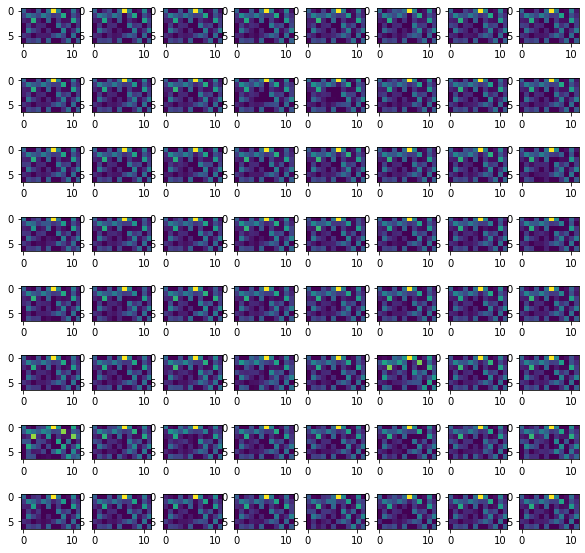

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_6[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

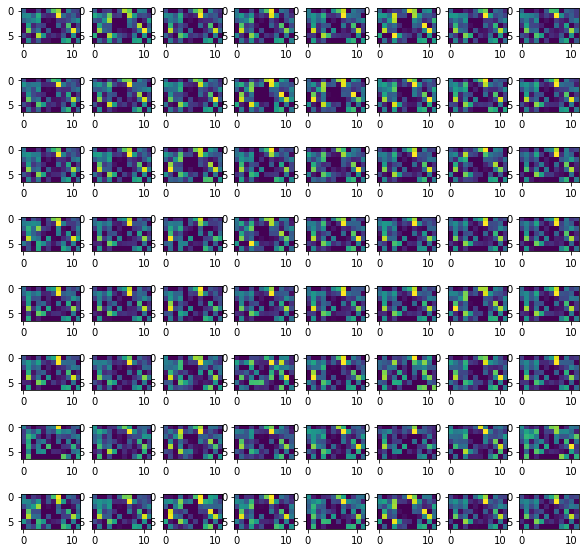

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_6[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

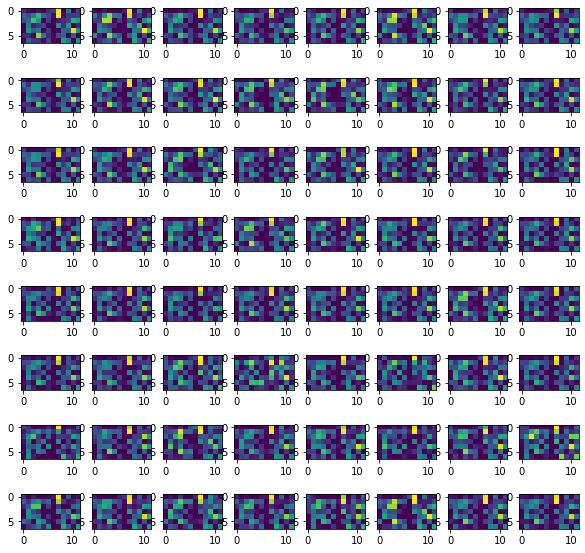

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_6[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

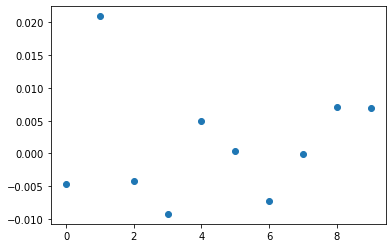

In [ ]:
#7

poison_model_7 = lenet()
model_save_name = 'poison_1_model_7.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_7.load_state_dict(torch.load(path))
poison_model_7.to(device)

poison_model_7.eval()
fhook7 = [Hook(layer[1]) for layer in list(poison_model_7._modules.items())]
w7 = poison_model_7.fc3.weight.data

# Load datasets
set_7 = class_extractor(trainset, 7)
poisoned_7 = poison_all(set_7)

set_7_loader = torch.utils.data.DataLoader(set_7, batch_size=64, shuffle=False)
poisoned_7_loader = torch.utils.data.DataLoader(poisoned_7, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w7.mean(dim = 1)))

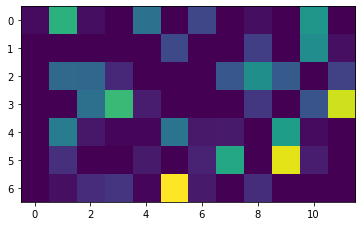

In [ ]:
delta_7 = poison_model_7(trigger)
delta_input_7 = fhook7[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_7[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_7_loader)
poisoned_iter = iter(poisoned_7_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_7(images)
inputs_7 = fhook7[-1].input[0]

poisoned_out = poison_model_7(poisoned_images)
poisoned_inputs_7 = fhook7[-1].input[0]

diff_7 = abs(poisoned_inputs_7 - inputs_7)

In [ ]:
# cosine similarity

cos_sim_7 = []
for i in range(64):
  cos_sim_7.append(torch.Tensor.cpu(cos(diff_7[i], delta_input_7[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_7))

Average cosine similarity in first batch is: 0.6366217


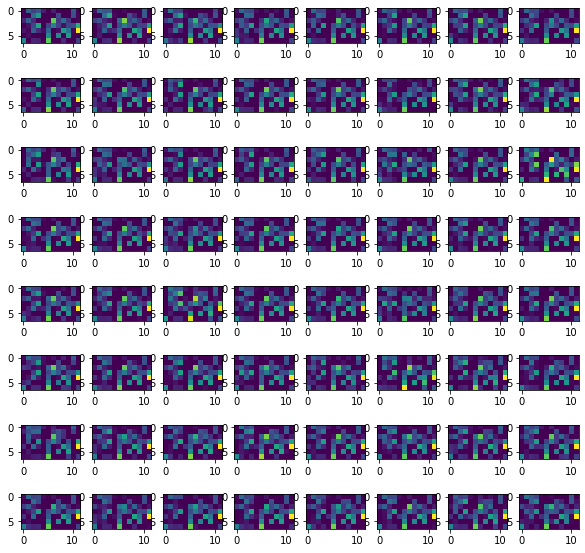

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_7[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

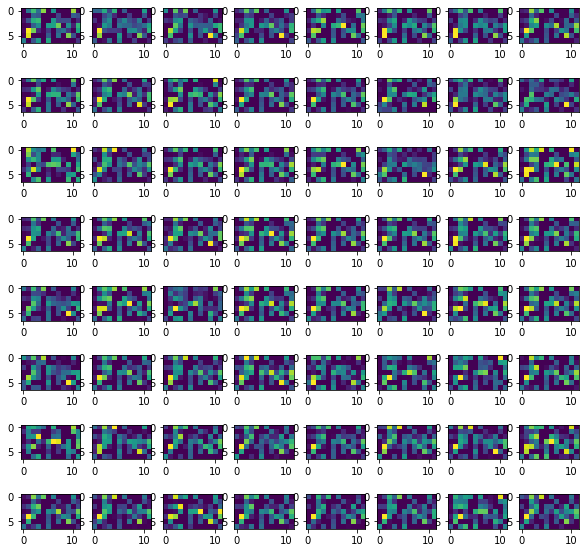

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_7[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

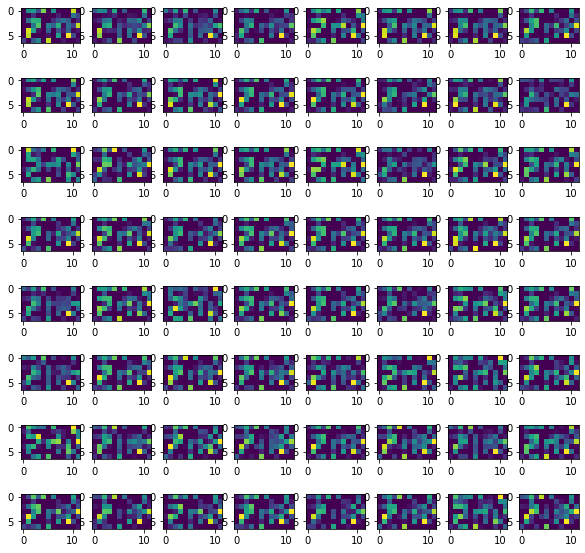

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_7[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

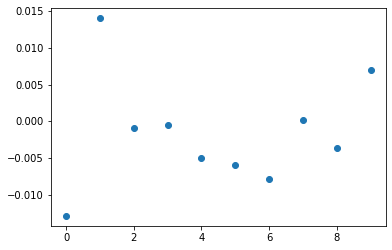

In [ ]:
#8

poison_model_8 = lenet()
model_save_name = 'poison_1_model_8.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_8.load_state_dict(torch.load(path))
poison_model_8.to(device)

poison_model_8.eval()
fhook8 = [Hook(layer[1]) for layer in list(poison_model_8._modules.items())]
w8 = poison_model_8.fc3.weight.data

# Load datasets
set_8 = class_extractor(trainset, 8)
poisoned_8 = poison_all(set_8)

set_8_loader = torch.utils.data.DataLoader(set_8, batch_size=64, shuffle=False)
poisoned_8_loader = torch.utils.data.DataLoader(poisoned_8, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w8.mean(dim = 1)))

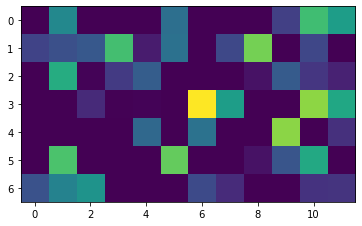

In [ ]:
delta_8 = poison_model_8(trigger)
delta_input_8 = fhook8[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_8[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_8_loader)
poisoned_iter = iter(poisoned_8_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_8(images)
inputs_8 = fhook8[-1].input[0]

poisoned_out = poison_model_8(poisoned_images)
poisoned_inputs_8 = fhook8[-1].input[0]

diff_8 = abs(poisoned_inputs_8 - inputs_8)

In [ ]:
# cosine similarity

cos_sim_8 = []
for i in range(64):
  cos_sim_8.append(torch.Tensor.cpu(cos(diff_8[i], delta_input_8[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_8))

Average cosine similarity in first batch is: 0.7529298


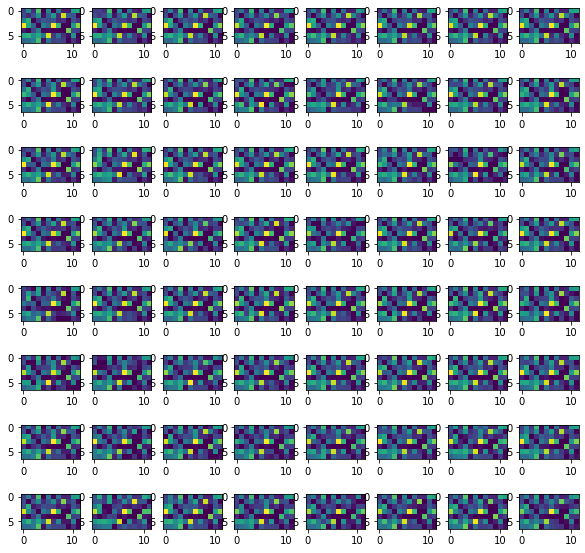

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_8[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

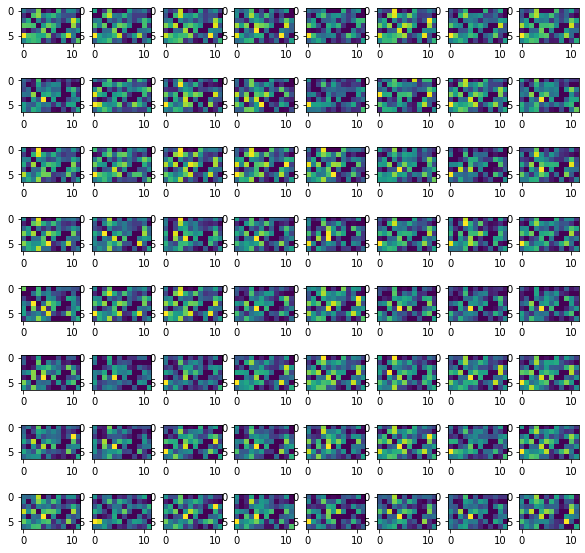

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_8[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

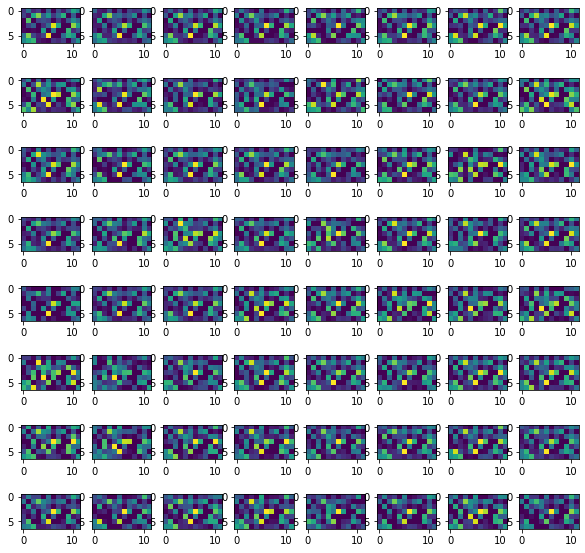

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_8[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

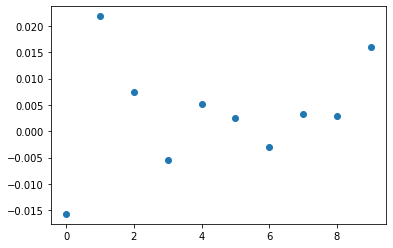

In [ ]:
#9

poison_model_9 = lenet()
model_save_name = 'poison_1_model_9.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
poison_model_9.load_state_dict(torch.load(path))
poison_model_9.to(device)

poison_model_9.eval()
fhook9 = [Hook(layer[1]) for layer in list(poison_model_9._modules.items())]
w9 = poison_model_9.fc3.weight.data

# Load datasets
set_9 = class_extractor(trainset, 9)
poisoned_9 = poison_all(set_9)

set_9_loader = torch.utils.data.DataLoader(set_9, batch_size=64, shuffle=False)
poisoned_9_loader = torch.utils.data.DataLoader(poisoned_9, batch_size=64, shuffle=False)

plt.scatter(range(10), torch.Tensor.cpu(w9.mean(dim = 1)))

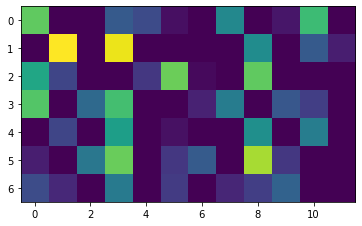

In [ ]:
delta_9 = poison_model_9(trigger)
delta_input_9 = fhook9[-1].input
plt.imshow(np.reshape(torch.Tensor.cpu(delta_input_9[0]).detach().numpy(), (7,12)))

In [ ]:
# add hooks and calculate differences for one batch

iterator = iter(set_9_loader)
poisoned_iter = iter(poisoned_9_loader)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

images, labels = iterator.next()
images = images.to(device)
poisoned_images, poisoned_labels = poisoned_iter.next()
poisoned_images = poisoned_images.to(device)

out = poison_model_9(images)
inputs_9 = fhook9[-1].input[0]

poisoned_out = poison_model_9(poisoned_images)
poisoned_inputs_9 = fhook9[-1].input[0]

diff_9 = abs(poisoned_inputs_9 - inputs_9)

In [ ]:
# cosine similarity

cos_sim_9 = []
for i in range(64):
  cos_sim_9.append(torch.Tensor.cpu(cos(diff_9[i], delta_input_9[0][0])).detach().data.numpy())

print("Average cosine similarity in first batch is:", np.mean(cos_sim_9))

Average cosine similarity in first batch is: 0.6551843


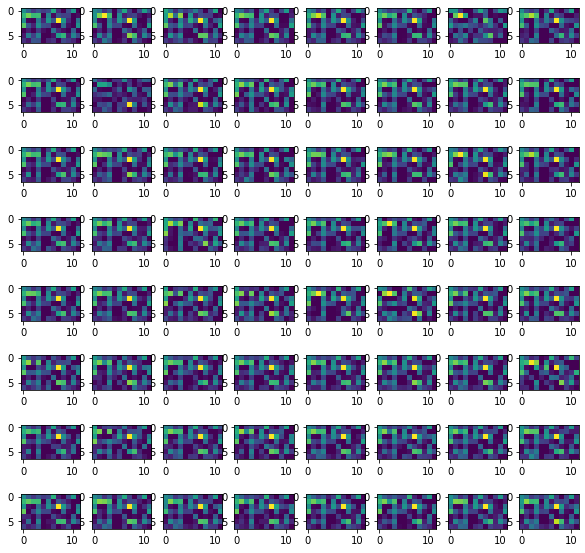

In [ ]:
# differences

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = diff_9[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))

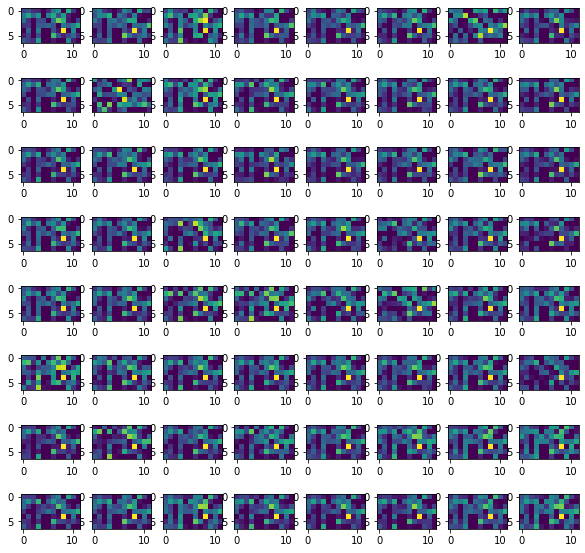

In [ ]:
# clean inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = inputs_9[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))


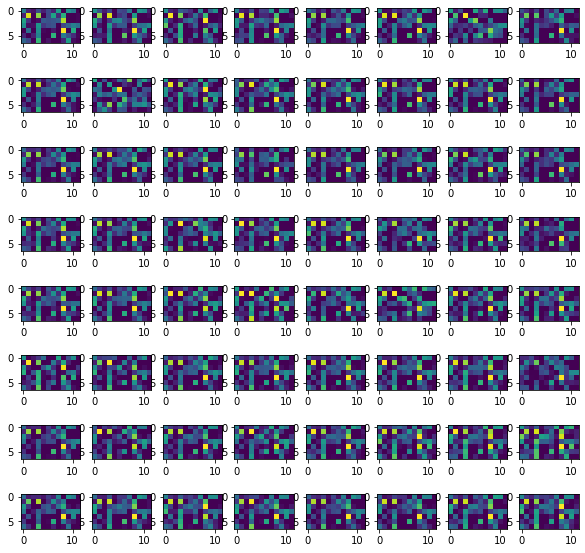

In [ ]:
# backdoored inputs

fig=plt.figure(figsize=(10, 10))
for i in range(64):
    image = poisoned_inputs_9[i]
    image = torch.Tensor.cpu(image).detach().numpy()
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(np.reshape(image, (7,12)))